In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import uncertainties.unumpy as unp
import matplotlib as mpl
import uncertainties as u
import os
from scipy.special import erfc
from lmfit import Model, fit_report
from datetime import datetime
from uncertainties import ufloat
from matplotlib import font_manager
from scipy.stats import chi2
from scipy.optimize import curve_fit
from IPython.display import Markdown

# Math Functions

In [97]:
def rect(x, b0, b1, mean):
    '''
    Descripción
    -----------
    Cálculo de una función lineal a partir de unos parámetros dados.
    
    Parámetros
    ----------
    x (float or np.array): Variable dependiente
    b0 (float): Corte con el eje y
    b1 (float): Pendiente
    mean (float): Centroide

    Retorna
    -------
    Arreglo (o valor individual) de la función evaluada en x
    '''
    return b0 + b1*(mean-x) #Background

##############################################################################

#Función Error Complemento
def rerfc(x, b0, b1, mean, stdev):
    '''
    Descripción
    -----------
    Función que calcula el fondo de un ajuste gaussiano describiendo la
    función error complemento adaptada a los parámetros de la gaussiana.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Cota inferior de la imagen de la función 
    b1 (float): Cota superior de la imagen de la función
    mean (float): Centroide de la gaussiana y de la función
    stdev (float): Desviación estándar de la gaussiana y se relaciona a la forma
                    en la que decae la función.
    
    Retorna
    -------
    Los valores de la función error complemento adaptada a la gaussiana del ajuste.
    '''
    return b0 + (b1/2)*erfc((x-mean)/(np.sqrt(2)*stdev)) #Background

##############################################################################

#Función Gaussiana con Fondo Lineal
def gaussian_rect(x, b0, b1, M, mean, stdev):
    '''
    Descripción
    -----------
    Función gaussiana sumada con la función error complemento.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Corte con el eje y
    b1 (float): Pendiente de la recta
    M (float): Amplitud de la gaussiana
    mean (float): Centroide del pico
    stdev (float): Desviación estándar

    Retorna
    -------
    Valores de la función gaussiana sobre el fondo modelado como una recta,
    correspondientes a los valores de x dados.
    
    '''
    return rect(x, b0, b1, mean) + M*np.exp(-(((mean-x)/stdev)**2)/2)

##############################################################################

#Función Gaussiana con fondo de la función error complemento
def gaussian_erfc(x, b0, b1, M, mean, stdev):
    '''
    Descripción
    -----------
    Función gaussiana sumada con la función error complemento.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Cota inferior de la imagen de la función 
    b1 (float): Cota superior de la imagen de la función
    M (float): Amplitud de la gaussiana
    mean (float): Centroide de la gaussiana y de la función
    stdev (float): Desviación estándar de la gaussiana y se relaciona a la forma
                    en la que decae la función.

    Retorna
    -------
    Valores de la función gaussiana sobre el fondo de la función error complemento
    correspondientes a los valores de x dados.
    '''
    return rerfc(x, b0, b1, mean, stdev) + M*np.exp(-(((mean-x)/stdev)**2)/2)

##############################################################################

#Error by Poisson's Distribution
def Poisson_Incertidumbre(y_values):
    '''
    Descripción
    -----------
    Se calcula la incertidumbre de los valores de las cuentas/canal de un espectro a
    partir del error de acuerdo a la distribución de Poisson.

    Parámetros
    ----------
    y_values (np.array): Valores de cuentas/canal en un espectro.

    Retorna:
    --------
    sigma_y (np.array): Valores de la incertidumbre asignada a los valores de las 
                        cuentas/canal de un espectro
    '''
    sigma_y = np.sqrt(np.abs(y_values))
    for i in range(len(y_values)):
        if y_values[i] == 0:
            sigma_y[i] = 1
    return sigma_y
#Función de 2 Gaussianas con Fondo Lineal
def gaussian_rect_2(x, b0, b1, M1, M2, mean1, mean2, stdev1, stdev2):
    '''
    Descripción
    -----------
    Función gaussiana sumada con la función error complemento.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Corte con el eje y
    b1 (float): Pendiente de la recta
    M (float): Amplitud de la gaussiana
    mean (float): Centroide del pico
    stdev (float): Desviación estándar

    Retorna
    -------
    Valores de la función gaussiana sobre el fondo modelado como una recta,
    correspondientes a los valores de x dados.
    
    '''
    return rect(x, b0, b1, (mean1+mean2)/2) + M1*np.exp(-(((mean1-x)/stdev1)**2)/2) + M2*np.exp(-(((mean2-x)/stdev2)**2)/2)

##############################################################################

#Función Gaussiana con fondo de la función error complemento
def gaussian_erfc_2(x, b0, b1, M1, M2, mean1, mean2, stdev1, stdev2):
    '''
    Descripción
    -----------
    Función gaussiana sumada con la función error complemento.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Cota inferior de la imagen de la función 
    b1 (float): Cota superior de la imagen de la función
    M (float): Amplitud de la gaussiana
    mean (float): Centroide de la gaussiana y de la función
    stdev (float): Desviación estándar de la gaussiana y se relaciona a la forma
                    en la que decae la función.

    Retorna
    -------
    Valores de la función gaussiana sobre el fondo de la función error complemento
    correspondientes a los valores de x dados.
    '''
    return rerfc(x, b0, b1, (mean1+mean2)/2, (stdev1+stdev2)/2) + M1*np.exp(-(((mean1-x)/stdev1)**2)/2) + M2*np.exp(-(((mean2-x)/stdev2)**2)/2)


# Formato grafico

In [98]:
#%% FORMATO GRAFICAS
def formato_grafico(ax=None, decimalx=None, decimaly=None, legend_loc='upper right'):
    if ax is None:
        ax = plt.gca()

    fuente = 'sans'
    ax.title.set_size(14)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.title.set_family(fuente)
    ax.yaxis.label.set_family(fuente)
    ax.xaxis.label.set_family(fuente)
    ax.tick_params(axis='both', labelsize=14)

    plt.rcParams['mathtext.fontset'] = 'cm'  
    plt.rcParams['mathtext.rm'] = 'sans'  
    plt.rcParams['mathtext.default'] = 'rm'

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    ax.tick_params(axis='x', direction='in', which='both', bottom=True, top=True)
    ax.tick_params(axis='y', direction='in', which='both', left=True, right=True)
    ax.tick_params(axis='x', which='minor', direction='in', bottom=True, top=True)
    ax.tick_params(axis='y', which='minor', direction='in', left=True, right=True)

    # Configurar la notación científica
    if decimalx is not None:
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimalx}f}' if x != 0 else '0'))

    if decimaly is not None:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimaly}f}' if x != 0 else '0'))

    if ax.get_legend() is not None:
        ax.legend(fontsize=16)

    font = font_manager.FontProperties(family='sans', style='normal', size=16)

    handles, labels = ax.get_legend_handles_labels()
    if handles and labels:
        ax.legend(loc=legend_loc, handles=handles, labels=labels, edgecolor='1', framealpha=0.5, prop=font)


# Fit functions

## Curvefit

## lmfit

In [99]:
def lmfit_custom_fit(x, y_with_unc, R, xmin, xmax):
    """
    Ajusta un modelo R a datos con incertidumbre usando lmfit. Calcula τ y κ con propagación
    de incertidumbre y los incluye como parámetros fijos en el fit_report.

    Parameters:
    - x (np.array): canales
    - y_with_unc (np.array of ufloat): cuentas con incertidumbre
    - R (function): modelo a ajustar (sin τ ni κ como parámetros)
    - xmin, xmax (int): índice de rango de ajuste

    Returns:
    - result (lmfit.model.ModelResult): resultado del ajuste con τ y κ incluidos
    - tau (ufloat): asimetría con incertidumbre
    - kappa (ufloat): curtosis con incertidumbre
    """

    # Separar nominales y desviaciones
    y_nom = unp.nominal_values(y_with_unc)
    y_err = unp.std_devs(y_with_unc)

    # Subconjunto del rango de ajuste
    x_fit = x[xmin:xmax]
    y_fit = y_nom[xmin:xmax]
    y_fit_err = y_err[xmin:xmax]

    # Estimaciones iniciales
    idx_max = np.argmax(y_fit)
    guess = {
        'b0': 1.0,
        'b1': 1.0,
        'M': y_fit[idx_max],
        'mean': x_fit[idx_max],
        'stdev': (xmax - xmin) / 6
    }

    # Crear modelo
    Rmodel = Model(R)
    params = Rmodel.make_params()

    params.add('b0', value=guess['b0'], vary=True)
    params.add('b1', value=guess['b1'], vary=True)
    params.add('M', value=guess['M'], vary=True, min=0)
    params.add('mean', value=guess['mean'], vary=True, min=0)
    params.add('stdev', value=guess['stdev'], vary=True, min=0)

    # Ajuste
    result = Rmodel.fit(y_fit, x=x_fit, params=params, weights=1/y_fit_err, nan_policy='omit')



    # Agregar τ y κ al resultado del modelo como parámetros fijos (para fit_report)
    #params.add('tau', value=unp.nominal_values(tau), vary=False)
    #params['tau'].stderr = unp.std_devs(tau)

    #params.add('kappa', value=unp.nominal_values(kappa), vary=False)
    #params['kappa'].stderr = unp.std_devs(kappa)

    # Inyectar esos params al result para que se muestren en el reporte
    #result.params.update(params)


    return result
# Markdown-compatible fit report with Q and Q2
def plot_and_markdown_fit_report(result, x, y, x_ajuste, y_ajuste, recta_ajuste,save_path,
                                  titulo="Ajuste", unidades="canal", ylim=None,
                                   show_plot=True):
    """
    Genera gráfica del ajuste + fit_report en formato Markdown extendido.

    Parameters:
    - result: objeto de resultado de lmfit
    - x, y: datos experimentales (sin incertidumbre)
    - x_ajuste: eje x del modelo ajustado
    - y_ajuste: modelo completo (recta + gauss)
    - recta_ajuste: modelo de fondo lineal
    - titulo: título del gráfico y nombre del archivo
    - unidades: 'canal' o 'keV'
    - ylim: límites opcionales para eje y
    - save_path: ruta donde guardar la imagen
    - show_plot: si se debe mostrar el gráfico en pantalla

    Returns:
    - Markdown fit report como objeto renderizable en Jupyter
    """

    # ----- GRAFICAR -----
    plt.figure(figsize=(10, 5))
    plt.step(x, y, 'k', label='{}'.format(titulo), where='mid')
    plt.plot(x_ajuste, y_ajuste, '--r', linewidth=2,
             label=r'$b_0 + b_1 (x - \mu) + M \exp \left[-\frac{(x-\mu)^2}{2\sigma^2} \right]$')
    plt.plot(x_ajuste, recta_ajuste, '--b', linewidth=2,
             label=r'$b_0 + b_1 (x - \mu)$')

    plt.grid()
    plt.title("")
    plt.ylabel(r'$I_{\gamma}$' + ' [cuentas / canal]')

    if unidades == 'canal':
        plt.xlabel(r'canal')
    elif unidades == 'keV':
        plt.xlabel(r'$E_{\gamma}$' + ' (keV)')

    if ylim:
        plt.ylim(ylim)

    formato_grafico()
    plt.tight_layout()
    if  save_path != None:
        filename = f"Practica2_{titulo.replace(' ', '_')}.png"
        full_path = os.path.join(save_path, filename)
        plt.savefig(full_path, dpi=300, bbox_inches='tight')

    if show_plot:
        plt.show()
      #-------- CALCULAR TAU Y KAPPA--------  
    # Recuperar parámetros ajustados con incertidumbre
    mean = ufloat(result.params['mean'].value, result.params['mean'].stderr)
    stdev = ufloat(result.params['stdev'].value, result.params['stdev'].stderr)

    # Diferencias para momentos centrales
    dif = x_ajuste - mean
    # Usar wrap para incertidumbre
    wrapped_mean = u.wrap(np.mean)

    momento_3 = wrapped_mean((dif)**3)
    momento_4 = wrapped_mean((dif)**4)

    tau = momento_3 / (stdev**3)
    kappa = momento_4 / (stdev**4)
        # ----- CALCULAR Q Y Q2 -----
    Chi2 = result.chisqr
    df = len(x) - len(result.params)
    Q = chi2.sf(Chi2, df)
    

    # ----- FIT REPORT -----
    report = fit_report(result, show_correl=False, min_correl=0.1).split('\n')


    extended_report = []
    for line in report:
        extended_report.append(line)
        if 'R-squared' in line:
            extended_report.append(f'     Q  = {Q:.8f}')
        if 'stdev' in line:
            extended_report.append(f'    Tau:    {tau:.8f}')
            extended_report.append(f'    Kappa:  {kappa:.8f}')
            extended_report.append(f'    df:  {df:.8f}')

    markdown_text = '```text\n' + '\n'.join(extended_report) + '\n```'
    return Markdown(markdown_text)

## ODR

# Main function

In [100]:
def load_spectrum_with_uncertainty(file_path):
    data = np.loadtxt(file_path, skiprows=1)
    channels = data[:, 0]
    counts = data[:, 1]
    uncertainties = Poisson_Incertidumbre(counts)
    spectrum_with_unc = unp.uarray(counts, uncertainties)
    return channels, spectrum_with_unc



def peak_fit(raw_data_path, background_path, 
             peak_configs, width=3.0,
             save_path="Imagenes", unidades="canal", ylim=None):
    """
    Carga datos crudos y de fondo, aplica propagación de incertidumbre y 
    muestra un gráfico del espectro corregido. Luego analiza los picos
    en los rangos especificados con el método indicado para cada pico.

    Parameters:
    - raw_data_path (str): Ruta al archivo de datos crudos
    - background_path (str): Ruta al archivo de fondo
    - peak_configs (list): Lista de diccionarios con la configuración de cada pico.
                          Cada diccionario debe tener las claves:
                          - "min_range": Canal mínimo
                          - "max_range": Canal máximo
                          - "method": Método a usar (1, 2, 3 o 4)
                          Ejemplo: [{"min_range": 100, "max_range": 150, "method": 1}, ...]
    - width (float): Factor para calcular el ancho del segundo ajuste (default: 3.0)
    - save_path (str): Ruta opcional para guardar el gráfico
    - unidades (str): Unidades para el eje x (default: "canal")
    - ylim (tuple): Límites para el eje y (opcional)

    Returns:
    - all_results (list): Lista con los resultados de todos los segundos ajustes
    """

    print(f"\n➡️ Cargando datos con incertidumbre de Poisson...")
    channels_raw, raw_with_unc = load_spectrum_with_uncertainty(raw_data_path)
    channels_back, background_with_unc = load_spectrum_with_uncertainty(background_path)

    if len(raw_with_unc) != len(background_with_unc):
        raise ValueError("⚠️ Raw data and background must be the same length.")

    corrected_data = raw_with_unc - background_with_unc
    corrected_counts = unp.nominal_values(corrected_data)

    # Número de picos basado en la longitud de peak_configs
    num_peaks = len(peak_configs)

    # Lista para almacenar los resultados
    all_results = []

    print(f"\n🧾 Procesando {num_peaks} picos...")

    for i in range(num_peaks):
        print(f"\n--- Pico #{i+1} ---")
    
        # Obtener configuración del pico actual
        config = peak_configs[i]
        min_range = config["min_range"]
        max_range = config["max_range"]
        method = config["method"]
    
        print(f"Usando rango: Canal mínimo = {min_range}, Canal máximo = {max_range}")
        print(f"Método seleccionado: {method}")
    
        try:
            # Seleccionar modelo según método especificado para este pico
            if method == 1:
                modelo = gaussian_rect
                model_name = "gaussian_rect"
            elif method == 2:
                modelo = gaussian_erfc
                model_name = "gaussian_erfc"
            elif method == 3:
                modelo = gaussian_rect_2
                model_name = "gaussian_rect_2"
            elif method == 4:
                modelo = gaussian_erfc_2
                model_name = "gaussian_erfc_2"
            else:
                raise ValueError(f"Método no válido para el pico #{i+1}. Usa 1, 2, 3 o 4.")
        
            # Convertir a índices de canal
            idx_min = int(np.searchsorted(channels_raw, min_range))
            idx_max = int(np.searchsorted(channels_raw, max_range))
        
            # Datos para ajuste
            x = channels_raw
            y_with_unc = corrected_data
        
            # Primer ajuste
            results = lmfit_custom_fit(x, y_with_unc, modelo, idx_min, idx_max)
            
            # Preparar datos para gráfica del primer ajuste
            x_data = x[idx_min:idx_max]
            y_nom = unp.nominal_values(y_with_unc[idx_min:idx_max])
            params = results.params
            x_ajuste = np.linspace(min_range, max_range, 500)
            
            # Calcular valores del modelo para la curva de ajuste
            if method == 1:
                y_ajuste = modelo(x_ajuste, **{k: params[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']})
                recta = params['b0'].value + params['b1'].value * (params['mean'] - x_ajuste)
            elif method == 2:
                y_ajuste = modelo(x_ajuste, **{k: params[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']})
                recta = params['b0'].value + (params['b1'].value)*erfc((x_ajuste - params['mean'])/(np.sqrt(2)*params['stdev']))
            elif method == 3:
                y_ajuste = modelo(x_ajuste, **{k: params[k].value for k in ['b0', 'b1', 'M1', 'M2', 'mean1', 'mean2', 'stdev1', 'stdev2']})
                recta = params['b0'].value + params['b1'].value * (0.5*(params['mean1'] + params['mean2']) - x_ajuste)
            elif method == 4:
                y_ajuste = modelo(x_ajuste, **{k: params[k].value for k in ['b0', 'b1', 'M1', 'M2', 'mean1', 'mean2', 'stdev1', 'stdev2']})
                # Promedio de dos funciones erfc para doble pico
                recta = params['b0'].value + (params['b1'].value) * 0.5 * (
                    erfc((x_ajuste - params['mean1'])/(np.sqrt(2)*params['stdev1'])) + 
                    erfc((x_ajuste - params['mean2'])/(np.sqrt(2)*params['stdev2']))
                )
            
            # Título automático para el primer ajuste
            titulo = f"Pico_{i+1}_{model_name}_primer_ajuste"
            
            # Graficar y mostrar Markdown report para el primer ajuste
            md = plot_and_markdown_fit_report(
                result=results,
                x=x_data,
                y=y_nom,
                x_ajuste=x_ajuste,
                y_ajuste=y_ajuste,
                recta_ajuste=recta,
                titulo=titulo,
                unidades=unidades,
                ylim=ylim,
                save_path=save_path,
                show_plot=True
            )
            display(md)
            
            # Realizar segundo ajuste con nuevos rangos calculados
            # Para métodos de doble pico, usamos el promedio de medias y desviaciones
            if method in [1, 2]:
                parameters = [params[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']]
                mean = parameters[3]
                stdev = parameters[4]
            else:  # Para métodos 3 y 4 (doble pico)
                mean1 = params['mean1'].value
                mean2 = params['mean2'].value
                stdev1 = params['stdev1'].value
                stdev2 = params['stdev2'].value
                # Usar el promedio o el valor más grande para determinar el rango
                mean = (mean1 + mean2) / 2
                stdev = max(stdev1, stdev2)
            
            x0_new = int(mean - width * stdev)
            x1_new = int(mean + width * stdev)
            
            print(f"Realizando segundo ajuste con rango: Canal mínimo = {x0_new}, Canal máximo = {x1_new}")
            
            # Convertir a índices de canal para el segundo ajuste
            idx_min_new = int(np.searchsorted(channels_raw, x0_new))
            idx_max_new = int(np.searchsorted(channels_raw, x1_new))
            
            # Segundo ajuste
            results_new = lmfit_custom_fit(x, y_with_unc, modelo, idx_min_new, idx_max_new)
            
            # Preparar datos para gráfica del segundo ajuste
            x_data_new = x[idx_min_new:idx_max_new]
            y_nom_new = unp.nominal_values(y_with_unc[idx_min_new:idx_max_new])
            params_new = results_new.params
            x_ajuste_new = np.linspace(x0_new, x1_new, 500)
            
            # Calcular valores del modelo y línea base para el segundo ajuste
            if method == 1:
                y_ajuste_new = modelo(x_ajuste_new, **{k: params_new[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']})
                recta_new = params_new['b0'].value + params_new['b1'].value * (params_new['mean'] - x_ajuste_new)
            elif method == 2:
                y_ajuste_new = modelo(x_ajuste_new, **{k: params_new[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']})
                recta_new = params_new['b0'].value + (params_new['b1'].value)*erfc((x_ajuste_new - params_new['mean'])/(np.sqrt(2)*params_new['stdev']))
            elif method == 3:
                y_ajuste_new = modelo(x_ajuste_new, **{k: params_new[k].value for k in ['b0', 'b1', 'M1', 'M2', 'mean1', 'mean2', 'stdev1', 'stdev2']})
                recta_new = params_new['b0'].value + params_new['b1'].value * (0.5*(params_new['mean1'] + params_new['mean2']) - x_ajuste_new)
            elif method == 4:
                y_ajuste_new = modelo(x_ajuste_new, **{k: params_new[k].value for k in ['b0', 'b1', 'M1', 'M2', 'mean1', 'mean2', 'stdev1', 'stdev2']})
                recta_new = params_new['b0'].value + (params_new['b1'].value) * 0.5 * (
                    erfc((x_ajuste_new - params_new['mean1'])/(np.sqrt(2)*params_new['stdev1'])) + 
                    erfc((x_ajuste_new - params_new['mean2'])/(np.sqrt(2)*params_new['stdev2']))
                )
            
            # Título automático para el segundo ajuste
            titulo_new = f"Pico_{i+1}_{model_name}_segundo_ajuste"
            
            # Graficar y mostrar Markdown report para el segundo ajuste
            md_new = plot_and_markdown_fit_report(
                result=results_new,
                x=x_data_new,
                y=y_nom_new,
                x_ajuste=x_ajuste_new,
                y_ajuste=y_ajuste_new,
                recta_ajuste=recta_new,
                titulo=titulo_new,
                unidades=unidades,
                ylim=ylim,
                save_path=save_path,
                show_plot=True
            )
            display(md_new)
            
            # Guardar resultados del segundo ajuste
            all_results.append(results_new)
            
        except Exception as e:
            print(f"❌ Error en el pico #{i+1}: {str(e)}")
            continue
    
    # Retornar todos los resultados del segundo ajuste
    return all_results

# Main block


➡️ Cargando datos con incertidumbre de Poisson...

🧾 Procesando 2 picos...

--- Pico #1 ---
Usando rango: Canal mínimo = 28, Canal máximo = 150
Método seleccionado: 3
❌ Error en el pico #1: Improper input: func input vector length N=11 must not exceed func output vector length M=0

--- Pico #2 ---
Usando rango: Canal mínimo = 200, Canal máximo = 250
Método seleccionado: 1


/tmp/ipykernel_6569/2879961313.py:143: RuntimeWarning: invalid value encountered in divide
  return rect(x, b0, b1, (mean1+mean2)/2) + M1*np.exp(-(((mean1-x)/stdev1)**2)/2) + M2*np.exp(-(((mean2-x)/stdev2)**2)/2)


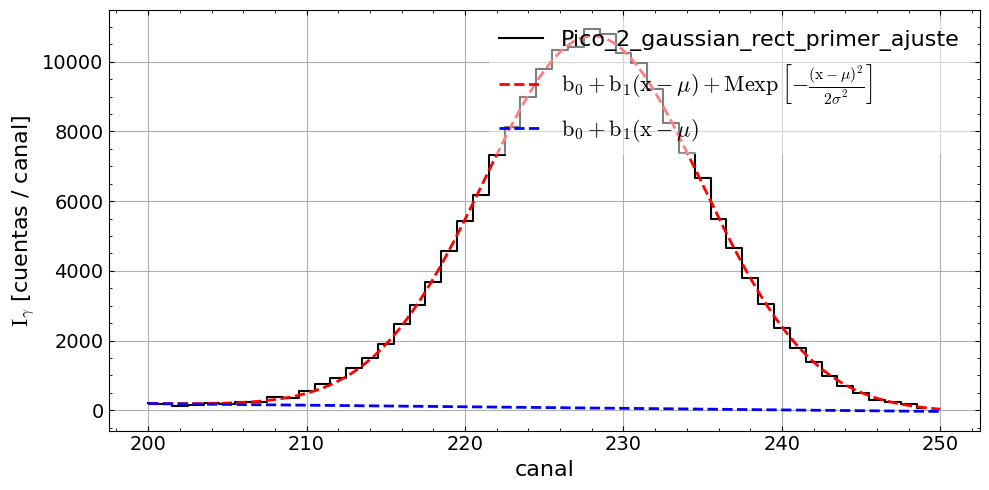

```text
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 50
    # variables        = 5
    chi-square         = 84.2566829
    reduced chi-square = 1.87237073
    Akaike info crit   = 36.0922441
    Bayesian info crit = 45.6523592
    R-squared          = 0.99954056
     Q  = 0.00035231
[[Variables]]
    b0:     65.5046668 +/- 11.8030732 (18.02%) (init = 1)
    b1:     4.49642698 +/- 0.45361075 (10.09%) (init = 1)
    M:      10674.3151 +/- 44.3610881 (0.42%) (init = 10937)
    mean:   228.068551 +/- 0.02710350 (0.01%) (init = 228)
    stdev:  6.89016757 +/- 0.02714556 (0.39%) (init = 8.333333)
    Tau:    -5.97488559+/-0.08910248
    Kappa:  40.22413060+/-0.64082618
    df:  45.00000000
```

Realizando segundo ajuste con rango: Canal mínimo = 207, Canal máximo = 248


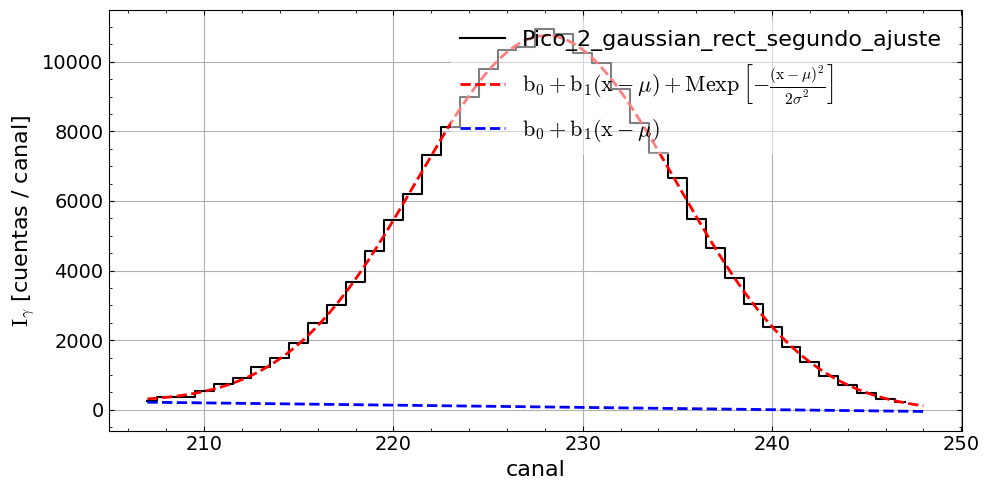

```text
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 41
    # variables        = 5
    chi-square         = 53.4950226
    reduced chi-square = 1.48597285
    Akaike info crit   = 20.9066784
    Bayesian info crit = 29.4745388
    R-squared          = 0.99954471
     Q  = 0.03040115
[[Variables]]
    b0:     81.4735041 +/- 17.6942648 (21.72%) (init = 1)
    b1:     6.48527625 +/- 0.68360178 (10.54%) (init = 1)
    M:      10671.5036 +/- 39.9025481 (0.37%) (init = 10937)
    mean:   228.110319 +/- 0.02675597 (0.01%) (init = 228)
    stdev:  6.86855406 +/- 0.02979412 (0.43%) (init = 6.833333)
    Tau:    -0.79540625+/-0.03643289
    Kappa:  16.13894279+/-0.28030139
    df:  36.00000000
```

In [101]:
# Definir los rangos de los picos
configuracion_picos = [
    {"min_range": 28, "max_range": 150, "method": 3},   # Pico 1 con método 1
    {"min_range": 200, "max_range": 250, "method": 1},  # Pico 2 con método 2

]

# Llamar a la función con la configuración especificada
resultados = peak_fit(
    raw_data_path="Informe2/Data/NaI_137Cs_600s.dat",
    background_path="Informe2/Data/NaI_Fondo_600s.dat",
    peak_configs=configuracion_picos,
    width=3.0,
    save_path="Imagenes",
    unidades="canal"
)